# Klausur

## Task 1

In [200]:
using Plots
using FFTW
using LaTeXStrings

In [201]:
"Computes gradient of a 2D scalar field"
function f_grad(T,Nx, Ny, Lx, Ly)
    diff_x = fill(0.0, (Nx,Ny))
    diff_y = fill(0.0, (Nx,Ny))
    diff = Matrix{Vector{Float64}}(undef, Nx, Ny)

    # Derivative in x direction
    for i in 1:size(T,2)
        diff_x[:,i] = f_diff(T[:,i],Nx,Lx)
    end

    # Derivative in y direction
    for i in 1:size(T,1)
        diff_y[i,:] = f_diff(T[i,:],Ny,Ly)
    end

    # Combines derivatives into vector field
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            diff[i,j] = copy([0.0,0.0])
            diff[i,j] = [diff_x[i,j],diff_y[i,j]]
        end
    end

    return diff
end

"Applies laplace operator onto scalar field T"
function laplace(T, Nx, Ny, Lx, Ly)
    diff_x = fill(0.0, (Nx,Ny))
    diff_y = fill(0.0, (Nx,Ny))
    diff = fill(0.0, (Nx,Ny))
    grad = f_grad(T, Nx, Ny, Lx, Ly)

    # Derivative in x direction
    for i in 1:size(T,2)
        diff_x[:,i] = f_diff(getindex.(grad,1)[:,i],Nx,Lx)
    end

    # Derivative in y direction
    for i in 1:size(T,1)
        diff_y[i,:] = f_diff(getindex.(grad,2)[i,:],Ny,Ly)
    end

    # Sums derivatives in x and y
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            diff[i,j] = diff_x[i,j] + diff_y[i,j]
        end
    end

    return diff
end


"Differentiates in fourier space"
function f_diff(x,N,L)
    k = fftfreq(N)*N
    diff = ifft(2*pi*im/L*k.*fft(x))
    return real(diff)
end

"Returns real fourier coeffs of v⋅∇T"
function v∇T(v,T,Nx,Ny,Lx,Ly)
    ∇T = f_grad(T,Nx,Ny,Lx,Ly)
    return fft(scalarProductVecField(v,∇T))
end

"Computes the element-wise scalar product of two vector fields"
function scalarProductVecField(a,b)
    return getindex.(a,1).*getindex.(b,1) + getindex.(a,2).*getindex.(b,2)
end

"Q"
function sourceTerm(x,y)
    return -2*pi^2*sin(4*pi*x)*cos(2*pi*y)*sin(2*pi*x)*sin(2*pi*y) - 4*pi^2*cos(4*pi*x)*sin(2*pi*y)*cos(2*pi*x)*cos(2*pi*y) + 4*pi^2*cos(2*pi*x)*sin(2*pi*y) + 4*pi^2*cos(2*pi*x)*sin(2*pi*y)
end

"Source term Q in fourier space"
function Q_hat(Nx,Ny,Lx,Ly)
    Q = fill(0.0,Nx,Ny)
    for i in 1:Nx
        for j in 1:Ny
            Q[i,j] = sourceTerm(Lx/(Nx+1)*(i-1),Ly/(Ny+1)*(j-1))
        end
    end
    return fft(Q)
end

"Time step of the temperature field"
function T_step(T_hist,v_hist,hats,Nx,Ny,Lx,Ly,Δt,Q)
    # Wave Vectors #
    kx = fftfreq(Nx)*Nx
    ky = fftfreq(Ny)*Ny


    # Calculate ℱ(v⋅∇T) #
    push!(hats,v∇T(v_hist[end],real(ifft(T_hist[end])),Nx,Ny,Lx,Ly))

    T = T_hist[end]
    T_new = copy(T)
   
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            T_new[i,j] = 1/(1+Δt*0.5*(kx[i]^2+ky[j]^2))*(T[i,j]+Δt*(-0.5*(kx[i]^2+ky[j]^2)*T[i,j]-0.5*(3*hats[end][i,j]-hats[end-1][i,j])+Q[i,j]))
        end
    end
    
    return T_new
end


T_step

In [202]:
"Calculates the sum of the elementwise absolute diffrence between two scalar fields"
function abs_change(a,b)
    diff = a - b
    change = sum(abs.(diff))
    return change
end

abs_change

In [260]:
function integrate(geometry,timestep,steps)
    Nx = geometry[1][1]
    Ny = geometry[1][2]
    Lx = geometry[2][1]
    Ly = geometry[2][2]

    # Initial temperature field #
    T = fill(0.0, (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            T[i,j] = 0
        end
    end

    # Initial velocity field #
    v = Matrix{Vector{Float64}}(undef, Nx, Ny)

    for i in 1:Nx
        for j in 1:Ny
            v[i,j] = copy([0.0,0.0])
            v[i,j][1] = pi*sin(4*pi*(Lx/(Nx+1))*(i-1))*cos(2*pi*(Ly/(Ny+1))*((j-1)))
            v[i,j][2] = -2*pi*cos(4*pi*(Lx/(Nx+1))*(i-1))*sin(2*pi*(Ly/(Ny+1))*((j-1)))
        end
    end


    T_hist = [fft(copy(T)),fft(copy(T))]
    v_hist = [copy(v),copy(v)]
    hats = [v∇T(v_hist[end - 1],real(ifft(T_hist[end - 1])),Nx,Ny,Lx,Ly)]
    Q = Q_hat(Nx,Ny,Lx,Ly)

    for in in 1:steps
        push!(T_hist,T_step(T_hist,v_hist,hats,Nx,Ny,Lx,Ly,timestep,Q))
    end

    return T_hist
end
function test_function(mode)
    Nx = 32
    Ny = 32
    Lx = 1.0
    Ly = 1.0

    geometry = ((Nx,Ny),(Lx,Ly))
    timestep = 0.001
    steps = 18
    

    if mode == "gif"
        anim = @animate for h in integrate(geometry,timestep,steps)
            #heatmap(real(ifft(h)),c= :magma)
            heatmap(real(ifft(h)))
        end every 10
        display(gif(anim, "heatmap.gif",fps=15))
    end


    # Plot maximum temperature to find stationaty solution #
    if mode == "max"
        maxx = []
        for h in integrate(geometry,timestep,steps)
            append!(maxx,maximum(real(ifft(h))))
        end
        display(plot(maxx))
    end
    Q = Q_hat(Nx,Ny,Lx,Ly)
    if mode == "v"
        # Initial velocity field #
        v = Matrix{Vector{Float64}}(undef, Nx, Ny)
        for i in 1:Nx
            for j in 1:Ny
                v[i,j] = copy([0.0,0.0])
                v[i,j][1] = pi*sin(4*pi*(Lx/(Nx+1))*(i-1))*cos(2*pi*(Ly/(Ny+1))*((j-1)))
                v[i,j][2] = -2*pi*cos(4*pi*(Lx/(Nx+1))*(i-1))*sin(2*pi*(Ly/(Ny+1))*((j-1)))
            end
        end
        #v[1,1][1] = 50
        plotx = heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),getindex.(v',1),title=L"$\vec{v}_y$",xlabel=L"$x$",ylabel=L"$y$",aspect_ratio=:equal,clim = (-5, 5))
        ploty = heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),getindex.(v',2),title=L"$\vec{v}_x$",xlabel=L"$x$",ylabel=L"$y$",aspect_ratio=:equal,clim = (-5, 5))
        display(plot(ploty,plotx,size=(800,400),link=:all,layout=(1,2),sharey = true, legend=:none))
    end

    if mode == "roc"
        cc = []
        for i in (0.0005,0.001,0.0019)
            c = []
            T_hist = integrate(geometry,i,steps)
            for i in 2:length(T_hist)
                push!(c,abs_change(real(ifft(T_hist[i])),real(ifft(T_hist[i-1]))))
            end
            push!(cc,c)
        end
        display(plot(cc,xlabel="Timesteps",ylabel=L"$\sum_{ij}\vert T_{ij}^n-T_{ij}^{n-1}\vert$",title=L"Difference between $T^n$ and $T^{n-1}$",ylim=(0,100),label=[0.0005 0.001 0.0019]))
    end
    #Sum of the absolute diffrence between temperature field $T^n$ and $T^{n-1}$
    if mode == "Q"
        display(heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),real(ifft(Q)),title=L"Source term $Q^\star$",aspect_ratio=:equal,xlabel=L"$x$",ylabel=L"$y$"))
        #Q_NEW = fft(real(ifft(Q)))

        #display(heatmap(real(ifft(Q_NEW))))
    end

end
test_function("Q")


LoadError: MethodError: no method matching display(::Plots.Plot{Plots.GRBackend}; aspect_ratio=:equal)
[0mClosest candidates are:
[0m  display(::Any) at /opt/julia-1.7.2/share/julia/base/multimedia.jl:324[91m got unsupported keyword argument "aspect_ratio"[39m
[0m  display() at /opt/julia/packages/IJulia/AQu2H/src/inline.jl:114[91m got unsupported keyword argument "aspect_ratio"[39m
[0m  display([91m::AbstractDisplay[39m, [91m::AbstractString[39m, [91m::Any[39m) at /opt/julia-1.7.2/share/julia/base/multimedia.jl:216[91m got unsupported keyword argument "aspect_ratio"[39m
[0m  ...

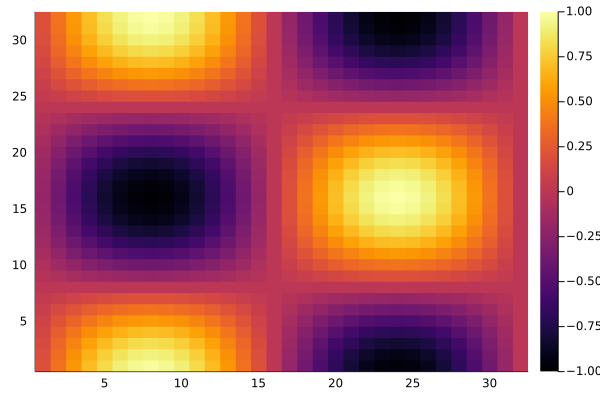

0.00.0303030303030303040.060606060606060610.090909090909090910.121212121212121220.151515151515151520.181818181818181820.212121212121212130.242424242424242430.27272727272727270.303030303030303040.333333333333333370.363636363636363650.39393939393939390.424242424242424250.45454545454545460.484848484848484860.51515151515151510.54545454545454540.57575757575757580.60606060606060610.63636363636363640.66666666666666670.6969696969696970.72727272727272730.75757575757575760.78787878787878780.81818181818181820.84848484848484850.87878787878787880.90909090909090920.9393939393939394

In [176]:
Nx = 32
Ny = 32
Lx = 1
Ly = 1

target = fill(0.0, (Nx,Ny))
for i in 1:Nx
    for j in 1:Ny
        target[i,j] = cos(2.0*pi*Lx/Nx*i)*sin(2*pi*Ly/Ny*j)
    end
end
display(heatmap(target))

for i in 1:Nx
    print((Lx/(Nx+1))*(i-1))
end